In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
from collections import Counter
import wfdb

import random
import glob

In [14]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Reshape, Flatten

/root/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dir_db = './physionet.org/physiobank/database/qtdb/'

In [3]:
file_list = glob.glob(dir_db+"/*.atr")
file_list = [f.rstrip(".atr") for f in file_list]
#sorted(file_list)

In [4]:
n_aug = 1
sample_size = 300 # Number of samples in each training instance

In [11]:
# Generate Input Vector
X = []
y = []

In [12]:
for record_id in file_list:

    record = wfdb.rdrecord(record_id)
    signal = record.p_signal

    intervals = []
    beat_annotation = wfdb.rdann(record_id, extension ='atr')
    beat_samples = beat_annotation.sample
    intervals.append(0)
    for i in range(len(beat_samples)-1):
        intervals.append(int((beat_samples[i] + beat_samples[i+1])/2))

    pos_annotation = wfdb.rdann(record_id, extension ='pu0')
    label_ids = np.array(pos_annotation.sample)
    symbols = np.array(pos_annotation.symbol)

    for r in range(n_aug):
        for i in range(0,len(intervals)-1):
            start = intervals[i]
            end = intervals[i+1]

            for c in range(signal.shape[1]):
            
                sample = signal[:,c][start: end]
                w = (sample_size - len(sample))//2
                if(w<0):continue
                offset = random.randint(0, w)

                sample_concat = np.zeros(sample_size)
                sample_concat[offset:offset+len(sample)] = sample
                sample_concat[offset+len(sample):] = sample[-1]

                # Removing Baseline drift using median filter (given sampling frequency 250hz)
                sample_concat = sample_concat - sg.medfilt(sample_concat, 125)
                X.append(sample_concat)

                # Label
                label_ids_ = label_ids[(label_ids>start) & (label_ids<=end)]
                symbols_ = symbols[np.where((label_ids>start) & (label_ids<=end))[0]]
                label_ids_ = label_ids_ - start
                target = np.zeros(3)
                if 'p' in symbols_:
                    target[0] = label_ids_[np.min(np.argwhere(symbols_=='p'))] / float(sample_size)
                else:
                    target[0] = 0.0
                if 'N' in symbols_:
                    target[1] = label_ids_[np.min(np.argwhere(symbols_=='N'))] / float(sample_size)
                else:
                    target[1] = 0.0
                if 't' in symbols_:
                    target[2] = label_ids_[np.max(np.argwhere(symbols_=='t'))] / float(sample_size)
                else:
                    target[2] = 0.0

                target += offset/float(sample_size)
                y.append(target)

X = np.array(X)
y = np.array(y)
X.dtype, y.dtype, X.shape, y.shape, X.max(), X.min(), y.max(), y.min()

(dtype('float64'),
 dtype('float64'),
 (165106, 300),
 (165106, 3),
 6.944999999999999,
 -5.11,
 0.9933333333333333,
 0.0)

## CNN + Dropout

In [15]:

# Convolutional Neural Network Architecture with Dropout

model = Sequential()

model.add(Conv1D(filters=16, kernel_size=5, input_shape=(300, 1), strides=3, padding='same'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(rate=0.2))

model.add(Conv1D(filters=32, kernel_size=5, padding='same', strides=3))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(rate=0.2))

model.add(Flatten())

model.add(Dense(units=150, activation='relu'))
model.add(Dense(units=3, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam')


In [17]:
history = model.fit(X[:,:,np.newaxis], y, validation_split=0.33, batch_size=32, epochs=10)

Train on 110621 samples, validate on 54485 samples
Epoch 1/10
110621/110621 [==============================] - 15s 134us/step - loss: 0.0023 - val_loss: 0.0052
Epoch 2/10
110621/110621 [==============================] - 14s 129us/step - loss: 0.0023 - val_loss: 0.0052
Epoch 3/10
110621/110621 [==============================] - 14s 128us/step - loss: 0.0022 - val_loss: 0.0053
Epoch 4/10
110621/110621 [==============================] - 14s 127us/step - loss: 0.0022 - val_loss: 0.0051
Epoch 5/10
110621/110621 [==============================] - 14s 128us/step - loss: 0.0022 - val_loss: 0.0051
Epoch 6/10
110621/110621 [==============================] - 14s 129us/step - loss: 0.0021 - val_loss: 0.0052
Epoch 7/10
110621/110621 [==============================] - 14s 125us/step - loss: 0.0021 - val_loss: 0.0054
Epoch 8/10
110621/110621 [==============================] - 15s 131us/step - loss: 0.0021 - val_loss: 0.0051
Epoch 9/10
110621/110621 [==============================] - 14s 126us/step - 

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 16)           96        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 16)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 17, 32)            2592      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
__________

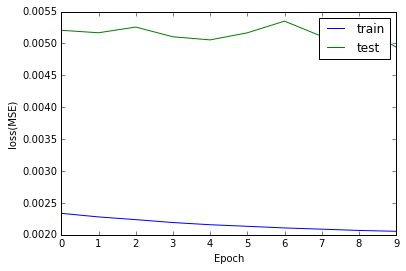

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('loss(MSE)')
plt.legend(['train', 'test'], loc='upper right')

[ 90 125 174] [ 78 123 172]
[  1  58 111] [ 3 49 92]
[ 75 119 187] [ 72 119 190]
[ 90 136 200] [ 91 136 203]
[ 88 119 168] [ 81 119 161]
[ 70 109 177] [ 62 109 173]
[131 177 217] [113 177 224]
[101 139 206] [ 94 139 203]


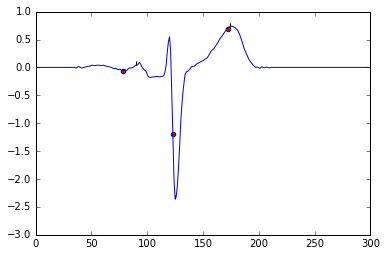

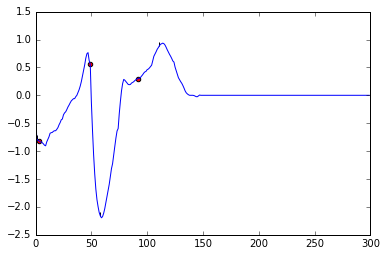

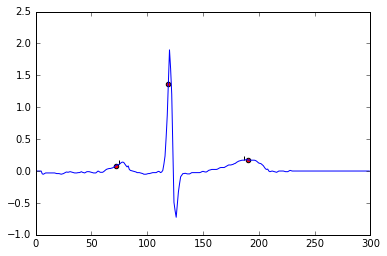

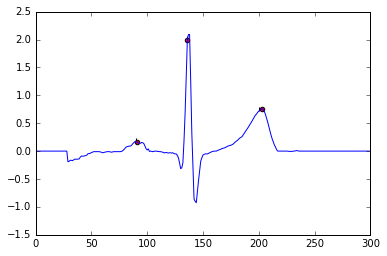

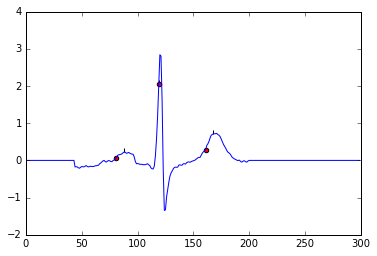

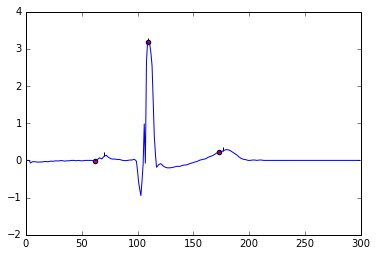

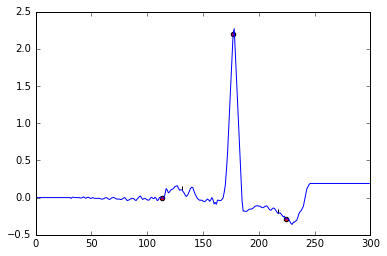

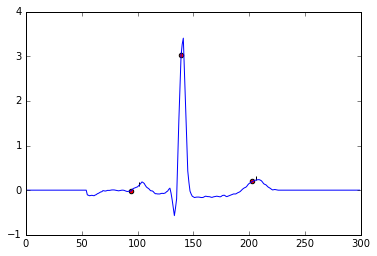

In [21]:
for i in range(10, len(X), len(X)//8):
    atr = (300.*y[i,:]).astype(np.int64)
    pred =(300.*model.predict( X[:,:,np.newaxis] )[i]).astype(np.int64)
    
    print(atr, pred)
    
    fig = plt.figure()
    plt.plot(X[i,:])
    plt.scatter(atr, X[i,atr], c='black', marker=2)
    plt.scatter(pred, X[i,pred], c='red')
    plt.xlim([0,300])
    #plt.ylim([-0.5,2.0])

## MFER sample

In [22]:
import numpy as np

In [23]:
X_mfer = np.load("mfer_sample.npy")
X_mfer.shape

(20, 300)

In [24]:
X_mfer.dtype, X_mfer.shape

(dtype('float64'), (20, 300))

In [25]:
X_mfer.max(), X_mfer.min()

(1.3430110000000002, -0.2793855)

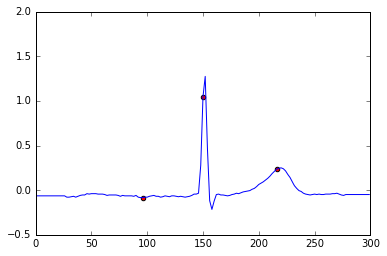

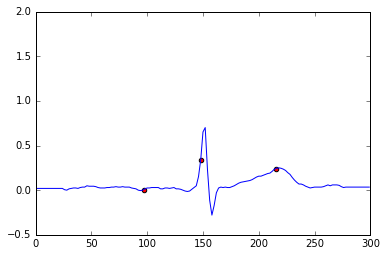

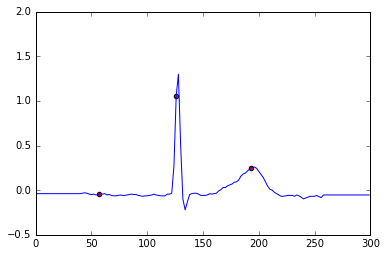

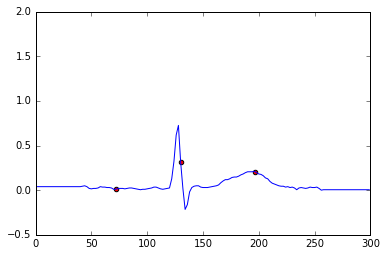

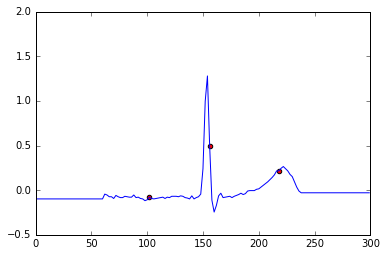

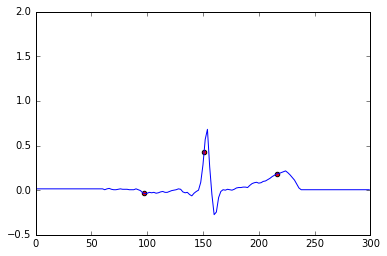

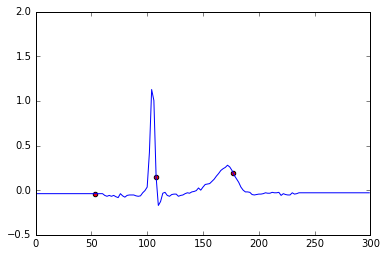

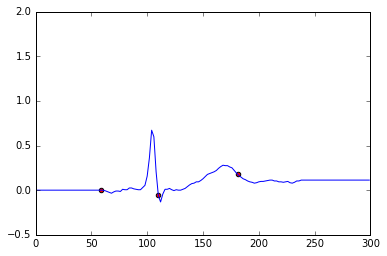

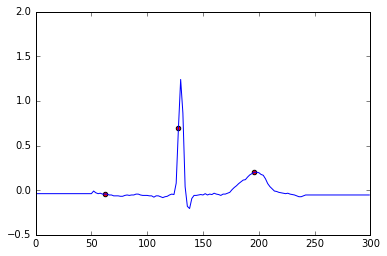

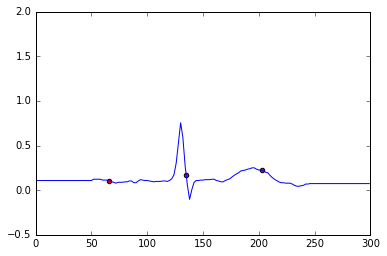

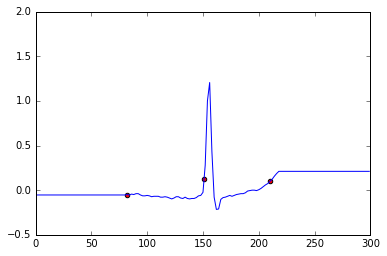

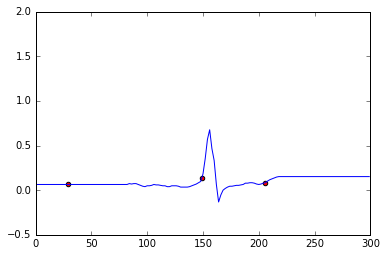

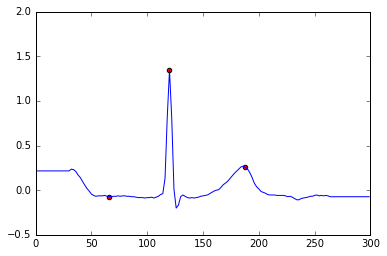

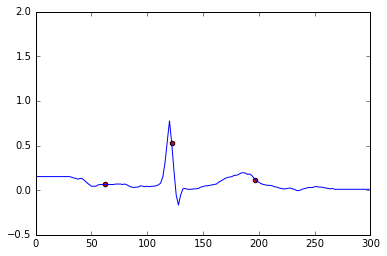

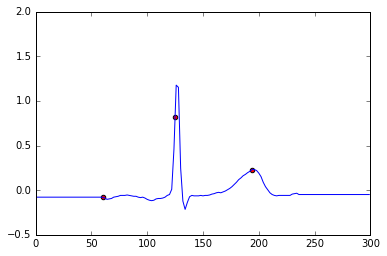

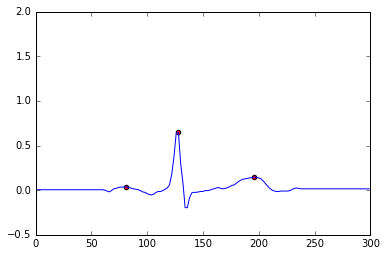

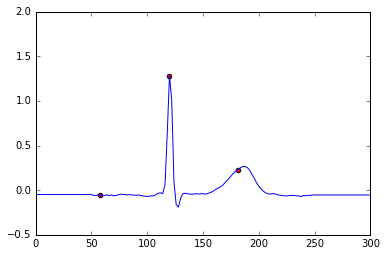

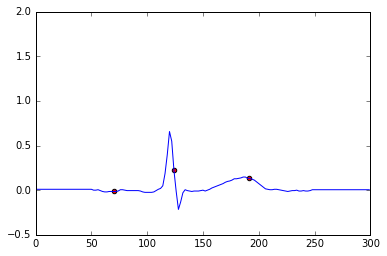

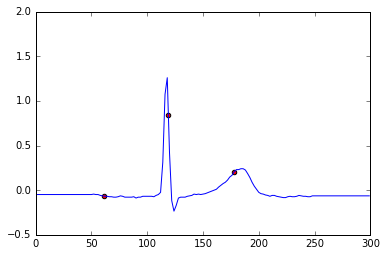

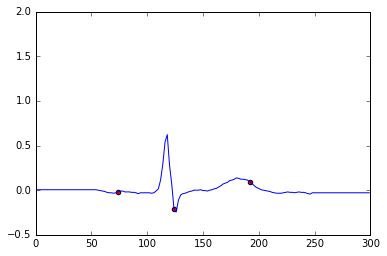

In [26]:
for i in range(X_mfer.shape[0]):

    pred = (300.*model.predict( X_mfer[:,:,np.newaxis] )[i]).astype(np.int64)

    fig = plt.figure()
    plt.plot(X_mfer[i,:])
    plt.scatter(pred, X_mfer[i,pred], c='red')
    plt.xlim([0,300])
    plt.ylim([-0.5,2.0])

## Fully connected MLP

In [28]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Reshape, Flatten

# Baseline Fully Connected Network

model = Sequential()
model.add(Dense(units=150, input_dim=300, activation='relu'))
model.add(Dense(units=3, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')


#history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0)
history = model.fit(X, y, validation_split=0.33, batch_size=32, epochs=100, verbose=0)

model.summary()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper right')

/root/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
